In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc

In [2]:
# Load dataset
df= pd.read_csv("C:/Users/prana/OneDrive/Desktop/loan_data.csv")

In [3]:
df.shape

(45000, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  int64  
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  int64  
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  int64  
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  int64  
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [5]:
df.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [6]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [7]:
# Encode target variable
from sklearn.preprocessing import OrdinalEncoder
oe= OrdinalEncoder()
for col in ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']:
    df[col]= oe.fit_transform(df[[col]])

In [8]:
# Normalize the feature
from sklearn.preprocessing import StandardScaler
sk= StandardScaler()
for col in ['person_income', 'loan_amnt']:
    df[col]= sk.fit_transform(df[[col]])

In [9]:
# Split into features and target
y= df['loan_status']
X= df.drop('loan_status', axis=1)

# Split the data into training(80%) and testing(20%) sets
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2, random_state=42)

In [10]:
# Handle class imbalance using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [11]:
# RandomForest Classifier Model
rf= RandomForestClassifier()
rf.fit(X_train, y_train)
y_pr= rf.predict(X_test)

# Accuracy using RandomForest Classifier Model
accuracy_score(y_test, y_pr)*100

92.57777777777778

In [12]:
# XGBoost Classifier Model
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.7, 1] }
# Grid search with 3-fold CV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)
# Best model from grid search
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Accuracy using XGBoost Classifier Model
accuracy_score(y_test, y_pred)*100

Fitting 3 folds for each of 54 candidates, totalling 162 fits


91.48888888888888

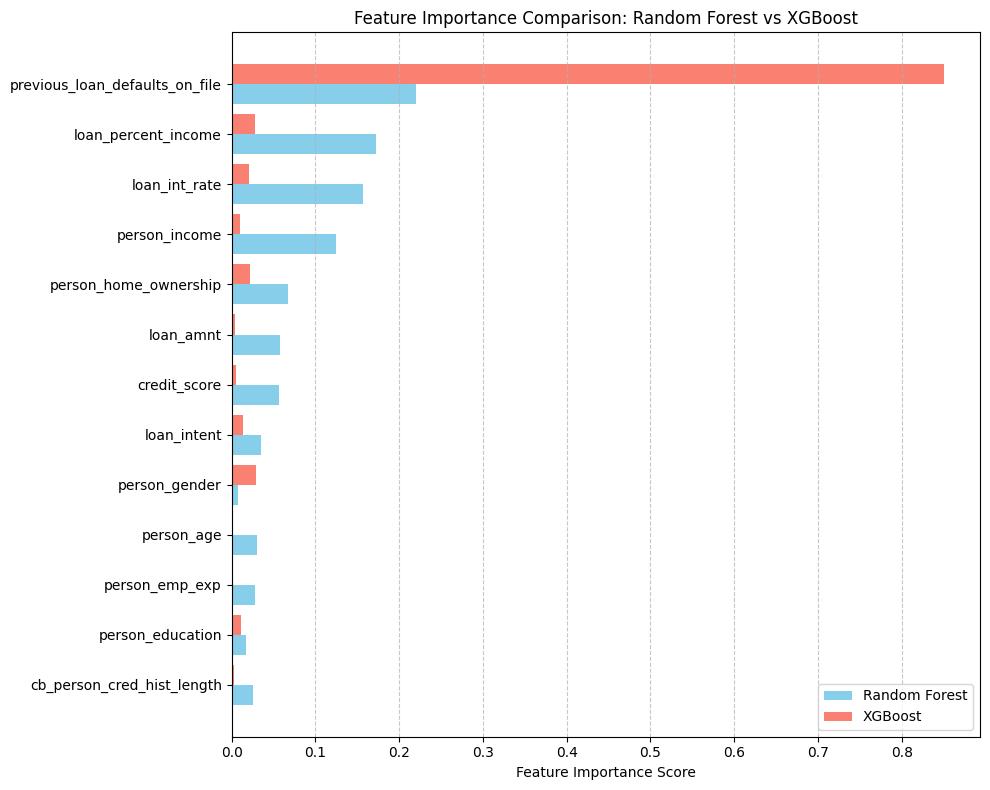

In [13]:
#Feature Importance Comparison: Random Forest vs XGBoost 
# Get feature importances from both models
rf_importance = rf.feature_importances_
xgb_importance = best_xgb.feature_importances_

# Create a DataFrame for both
feature_names = X.columns
comparison_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest': rf_importance,
    'XGBoost': xgb_importance
})
# Sort by average importance for better visualization
comparison_df['Mean'] = comparison_df[['Random Forest', 'XGBoost']].mean(axis=1)
comparison_df = comparison_df.sort_values(by='Mean', ascending=True)

# Plot
plt.figure(figsize=(10, 8))
bar_width = 0.4
y = np.arange(len(comparison_df))
plt.barh(y, comparison_df['Random Forest'], height=bar_width, label='Random Forest', color='skyblue')
plt.barh(y + bar_width, comparison_df['XGBoost'], height=bar_width, label='XGBoost', color='salmon')
plt.yticks(y + bar_width / 2, comparison_df['Feature'])

# Formatting
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance Comparison: Random Forest vs XGBoost')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

ROC-AUC Score for Random Forest: 0.9729
ROC-AUC Score for XGBoost: 0.9689


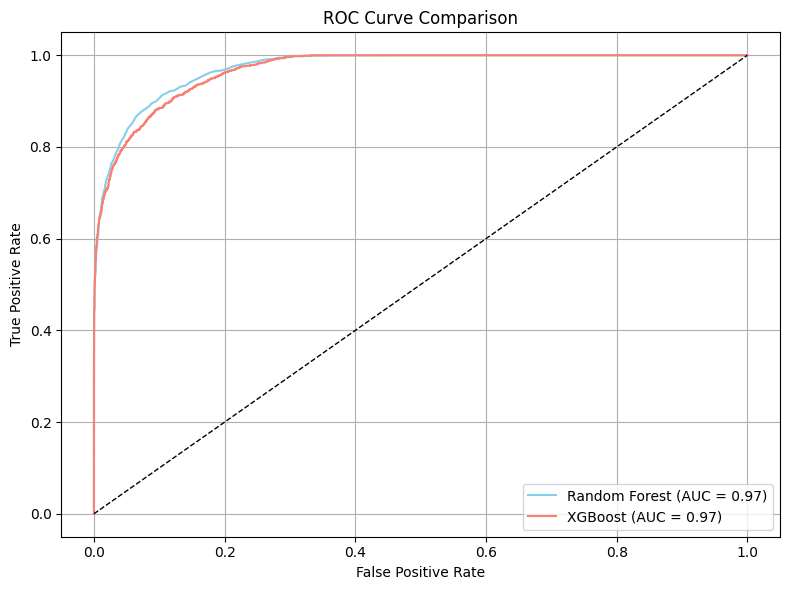

In [14]:
#ROC Curve Comparison: Random Forest vs XGBoost
# 1. Predict probabilities
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = best_xgb.predict_proba(X_test)[:, 1]

# 2. Get ROC curve and AUC for both models
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# 3. Print AUC Scores
print("ROC-AUC Score for Random Forest: {:.4f}".format(auc_rf))
print("ROC-AUC Score for XGBoost: {:.4f}".format(auc_xgb))

# 4. Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(auc_rf), color='skyblue')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(auc_xgb), color='salmon')

# Reference line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()